In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [2]:
BTC_21 = pd.read_csv('BTC_21.csv', index_col = 'timestamp')
BTC_21.index = BTC_21.index.map(datetime.fromtimestamp)

In [3]:
####### Meta data #########
prior_period_time = 3*60 # 4 hour period
forecast_period = 60 # one hour
train_period = 30 * 1440 # 30 days
target = 'Open'
short_std = 2 * 60 # 2 hour timeframe to calculate short term variation
long_std = 6 * 60 # 6 hour timeframe to calculate long term variation


In [4]:
np.random.seed(123)
def create_train_test_dataframes(BTC_21, train_period, forecast_period):
    train_start = np.random.randint(0, BTC_21.shape[0] - train_period - forecast_period, 1)[0]
    train_end = train_start + train_period
    test_start = train_end + 1
    test_end = test_start + forecast_period

    train_df = BTC_21.iloc[train_start:train_end, :]
    test_df = BTC_21.iloc[test_start:test_end, :]
    return train_df, test_df
train_df, test_df = create_train_test_dataframes(BTC_21, train_period, forecast_period)
# orig_df = train_df.copy() # as this will be used to create time-frame based features

## visualize the Open data

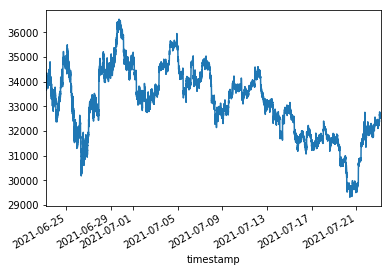

/usr/local/anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


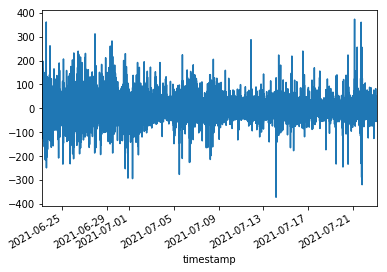

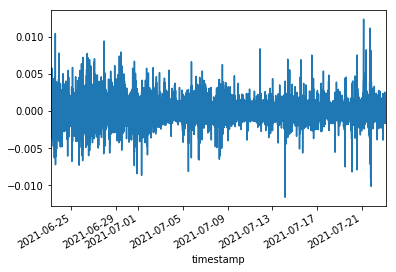

In [5]:
train_df.Open.plot()
plt.show()
train_df.loc[:, 'log_Open'] = np.log(train_df.Open)
train_df.loc[:, 'Open_diff'] = train_df.loc[:, 'Open'].diff()
train_df.Open_diff.plot()
plt.show()
train_df.loc[:, 'log_open_diff'] = train_df.loc[:, 'log_Open'].diff()
train_df.log_open_diff.plot()

## Engineer Features

In [6]:
def engineer_features(train_df, test_df, prior_period_time):

    train_df.loc[:, 'green_candel'] = np.where(train_df.Close > train_df.Open, 1, 0)
    train_df.loc[:, 'top_shadow'] = train_df.loc[:, 'High'] - train_df.loc[:, ['Open', 'Close']].max(axis = 1)
    train_df.loc[:, 'bottom_shadow'] = train_df.loc[:, ['Open', 'Close']].min(axis = 1) - train_df.loc[:, 'Low']
    train_df.loc[:, 'weekday'] = train_df.index.dayofweek
    train_df.loc[:, 'hour'] = train_df.index.hour
    train_df.loc[:, 'isweekend'] = (train_df.loc[:, 'weekday'] > 4).astype(int)
    train_df.loc[:, 'avg_green_candel'] = train_df.loc[:, 'green_candel'].rolling(window = prior_period_time).mean()
    train_df.loc[:, 'avg_top_shadow'] = train_df.loc[:, 'top_shadow'].rolling(window = prior_period_time).mean()
    train_df.loc[:, 'avg_bottom_shadow'] = train_df.loc[:, 'bottom_shadow'].rolling(window = prior_period_time).mean()
    train_df.loc[:, 'log_Open'] = np.log(train_df.Open)
    # find the average 2 hour variance to 10 hour variance
    train_df.loc[:, 'short_std'] = train_df.loc[:, 'Open'].rolling(window = short_std).std()
    train_df.loc[:, 'long_std'] = train_df.loc[:, 'Open'].rolling(window = long_std).std()
    train_df.loc[:, 'relative_variation'] = train_df.short_std.divide(train_df.long_std)
    columns_to_transfer = ['avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow', 'short_std', 'long_std', 'relative_variation']
    test_features_df = pd.DataFrame(np.repeat(train_df.tail(1)[columns_to_transfer].values, test_df.shape[0], axis = 0), 
                       index = test_df.index, columns = columns_to_transfer)
    test_df.loc[:, 'weekday'] = test_df.index.dayofweek
    test_df.loc[:, 'hour'] = test_df.index.hour
    test_df.loc[:, 'isweekend'] = (test_df.loc[:, 'weekday'] > 4).astype(int)
    test_df.loc[:, 'log_Open'] = np.log(test_df.Open)
    test_df = pd.concat([test_df, test_features_df], axis = 'columns')
    return train_df, test_df
train, test = engineer_features(train_df, test_df, prior_period_time)
train = train.dropna()

In [7]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_Open,...,bottom_shadow,weekday,hour,isweekend,avg_green_candel,avg_top_shadow,avg_bottom_shadow,short_std,long_std,relative_variation
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-23 09:50:00,1,1610.0,33965.710000,33994.770000,33941.02,33982.944939,142.747463,33973.022515,-0.001763,10.433107,...,24.690000,2,9,0,0.494444,29.800943,32.409309,112.663769,142.774194,0.789105
2021-06-23 09:51:00,1,1605.0,33987.083699,34022.000000,33969.95,34005.371429,49.814824,33995.188325,-0.001888,10.433736,...,17.133699,2,9,0,0.494444,29.779681,32.253424,112.470948,142.618771,0.788613
2021-06-23 09:52:00,1,1530.0,34007.046086,34055.995918,33981.72,34037.057143,74.629648,34020.154310,-0.001942,10.434323,...,25.326086,2,9,0,0.500000,29.783357,32.199974,112.272494,142.519832,0.787768
2021-06-23 09:53:00,1,1756.0,34030.450000,34053.476447,33960.69,34008.721100,88.274573,34010.864167,-0.001459,10.435011,...,48.031100,2,9,0,0.500000,29.553858,32.222932,111.986249,142.424572,0.786285
2021-06-23 09:54:00,1,1189.0,34005.832857,34034.000000,33980.00,34004.798571,67.159357,34006.383994,-0.000102,10.434287,...,24.798571,2,9,0,0.494444,29.533698,32.202924,111.798781,142.417631,0.785007


## ARIMAX model

In [8]:
arimax_model = SARIMAX(endog = train[target], order = (1, 1, 1), 
                       exog = train[['avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow', 'hour', 'isweekend', \
                                     'short_std', 'long_std', 'relative_variation']])
res = arimax_model.fit(disp = False)

/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [9]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Open   No. Observations:                42841
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -206940.785
Date:                Fri, 19 Nov 2021   AIC                         413903.570
Time:                        06:08:57   BIC                         413998.887
Sample:                             0   HQIC                        413933.644
                              - 42841                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
avg_green_candel     163.5880     37.517      4.360      0.000      90.057     237.119
avg_top_shadow         9.4185      0.386     24.427      0.000       8.663      10.174
avg_bottom_shadow    -12.3401      0.194    -63.573      0.000     -12.721     -11.960
hour                  -0.4275      0.205     -2.083      0.037      -0.830      -0.025
isweekend            -17.3674     10.069     -1.725      0.085     -37.102       2.368
short_std             -0.0258      0.076     -0.340      0.734      -0.175       0.123
long_std              -0.1201      0.104     -1.158      0.247      -0.323       0.083
relative_variation    18.3933     12.871      1.429      0.153      -6.832      43.619
ar.L1                 -0.1976      0.043     -4.616      0.000      -0.282      -0.114
ma.L1                  0.2682      0.043      6.296      0.000       0.185       0.352
sigma2               919.1280      2.597    353.879      0.000     914.037     924.219
===================================================================================
Ljung-Box (Q):                      226.81   Jarque-Bera (JB):            187282.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## generate forecasts and see the results

In [10]:
# first run the model on the trained dataset
model_infere = res.get_prediction().predicted_mean
# now run the model on unobserved model
test_exog = test[['hour', 'isweekend', 'avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow', 
                 'short_std', 'long_std', 'relative_variation']]
model_forecasts = res.forecast(steps = forecast_period, exog = test_exog)

/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [11]:
# # In-sample one-step-ahead predictions
# train_predictions = res.get_prediction().predicted_mean
# fig, ax = plt.subplots(figsize = (10, 5))
# train_predictions[-200:].plot(ax = ax, style='r--', label='One-step-ahead forecast')
# train.Open[-200:].plot(ax=ax, style='o', label='Observed')


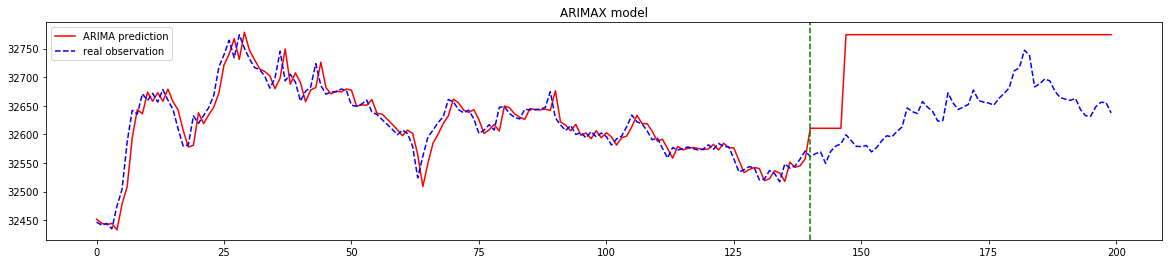

In [12]:
def plot_obs_preds(model_infere, model_forecast, train, test):
    predicted_y = np.array(list(model_infere.values) + list(model_forecast.values))[-200:]
    real_y = np.array(list(train[target].values) + list(test[target].values))[-200:]
    plt.figure(figsize = (20, 4))
    plt.plot(predicted_y, label = 'ARIMA prediction', color = 'red')
    plt.plot(real_y, label = 'real observation', color ='blue', linestyle = 'dashed')
    plt.title('ARIMAX model')
    plt.legend()
    forecast_point = len(predicted_y) - len(model_forecast)
    plt.axvline(forecast_point, linestyle = '--', color = 'green')
    plt.show()
plot_obs_preds(model_infere = model_infere, model_forecast = model_forecasts, train = train, test = test)

## Put them altogether

In [13]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,log_Open,...,bottom_shadow,weekday,hour,isweekend,avg_green_candel,avg_top_shadow,avg_bottom_shadow,short_std,long_std,relative_variation
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-23 09:50:00,1,1610.0,33965.710000,33994.770000,33941.02,33982.944939,142.747463,33973.022515,-0.001763,10.433107,...,24.690000,2,9,0,0.494444,29.800943,32.409309,112.663769,142.774194,0.789105
2021-06-23 09:51:00,1,1605.0,33987.083699,34022.000000,33969.95,34005.371429,49.814824,33995.188325,-0.001888,10.433736,...,17.133699,2,9,0,0.494444,29.779681,32.253424,112.470948,142.618771,0.788613
2021-06-23 09:52:00,1,1530.0,34007.046086,34055.995918,33981.72,34037.057143,74.629648,34020.154310,-0.001942,10.434323,...,25.326086,2,9,0,0.500000,29.783357,32.199974,112.272494,142.519832,0.787768
2021-06-23 09:53:00,1,1756.0,34030.450000,34053.476447,33960.69,34008.721100,88.274573,34010.864167,-0.001459,10.435011,...,48.031100,2,9,0,0.500000,29.553858,32.222932,111.986249,142.424572,0.786285
2021-06-23 09:54:00,1,1189.0,34005.832857,34034.000000,33980.00,34004.798571,67.159357,34006.383994,-0.000102,10.434287,...,24.798571,2,9,0,0.494444,29.533698,32.202924,111.798781,142.417631,0.785007


/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


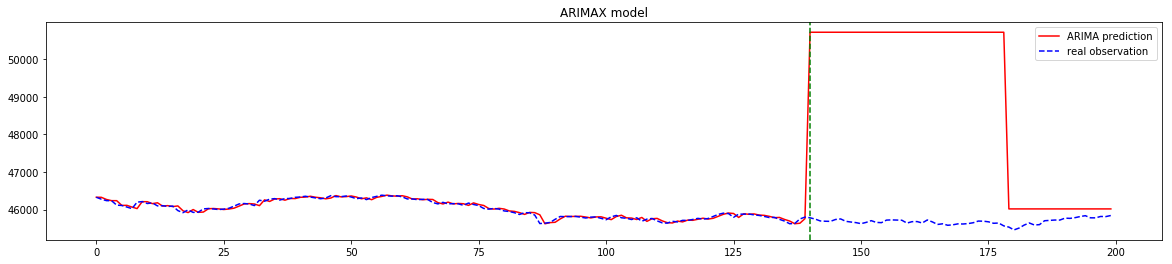

/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/anaconda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


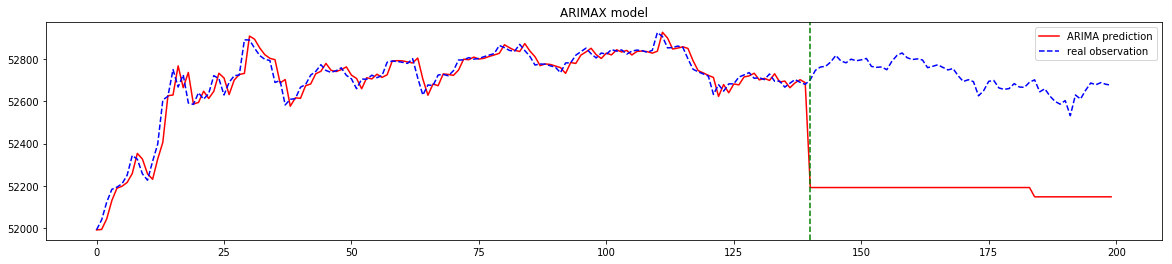

In [14]:
fold_nubmer = 2
for i in range(fold_nubmer):
    # create random starting point train and test sets
    train_df, test_df = create_train_test_dataframes(BTC_21, train_period, forecast_period)
    # engineer the featutes
    train, test = engineer_features(train_df, test_df, prior_period_time)
    train = train.dropna()
    # create the model
    arimax_model = SARIMAX(endog = train[target], order = (1, 1, 1), 
                           exog = train[['avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow', 'hour', 'isweekend', 'short_std', 'long_std', 'relative_variation']])
    res = arimax_model.fit(disp = False)
    # run model on train and test set
    model_infere = res.get_prediction().predicted_mean
    test_exog = test[['hour', 'isweekend', 'avg_green_candel', 'avg_top_shadow', 'avg_bottom_shadow', 'short_std', 'long_std', 'relative_variation']]
    test_exog.to_csv('test_ds_' + str(i) + '.csv')
    model_forecasts = res.forecast(steps = forecast_period, exog = test_exog)
    # plot results
    plot_obs_preds(model_infere = model_infere, model_forecast = model_forecasts, train = train, test = test)

In [15]:
model_infere[:10]

timestamp
2021-01-20 17:10:00      119.112152
2021-01-20 17:11:00    34803.479146
2021-01-20 17:12:00    34778.940118
2021-01-20 17:13:00    34771.633790
2021-01-20 17:14:00    34744.068980
2021-01-20 17:15:00    34758.413109
2021-01-20 17:16:00    34748.450215
2021-01-20 17:17:00    34754.951577
2021-01-20 17:18:00    34762.760607
2021-01-20 17:19:00    34818.776475
dtype: float64